# Advanced Lane Finding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

from lanetracker.tracker import LaneTracker
from lanetracker.camera import CameraCalibration
from lanetracker.gradients import get_edges
from lanetracker.perspective import flatten_perspective

%matplotlib inline
%load_ext autoreload
%autoreload 2

Camera calibration

Correction images (successfully detected corners):


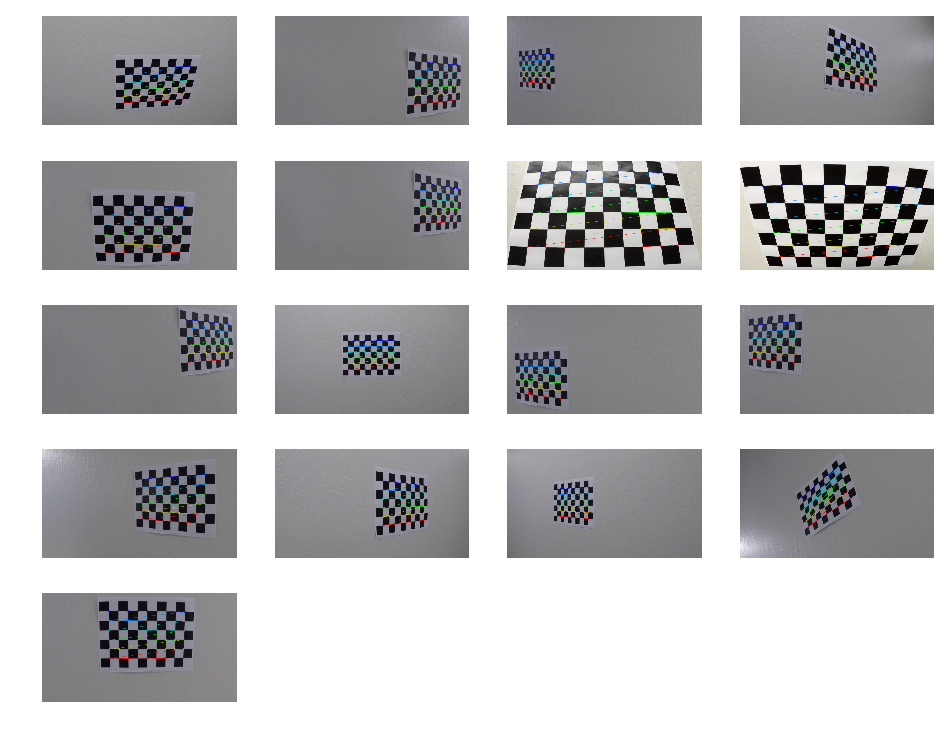


Test images (failed to detect corners):


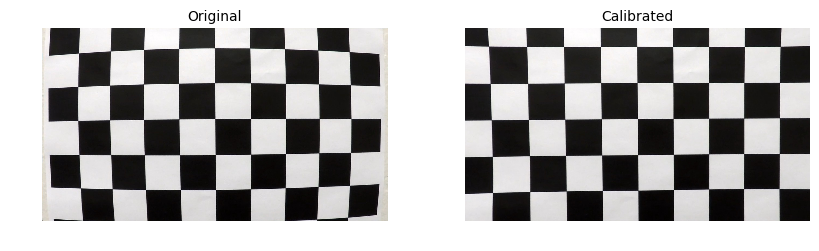

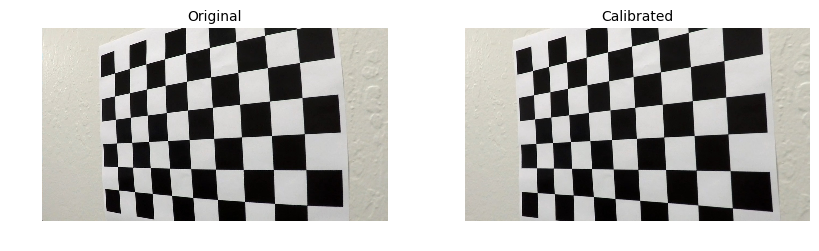

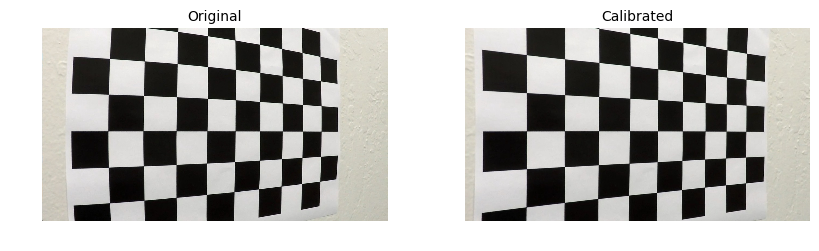

In [2]:
calibrate = CameraCalibration(glob.glob('camera_cal/calibration*.jpg'), retain_calibration_images=True)

print('Correction images (successfully detected corners):')
plt.figure(figsize = (11.5, 9))
gridspec.GridSpec(5, 4)
# Step through the list and search for chessboard corners
for i, image in enumerate(calibrate.calibration_images_success):
    plt.subplot2grid((5, 4), (i // 4, i % 4), colspan=1, rowspan=1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

print('\nTest images (failed to detect corners):')
for i, image in enumerate(calibrate.calibration_images_error):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=10)
    ax2.axis('off')
    ax2.imshow(calibrate(image))
    ax2.set_title('Calibrated', fontsize=10)

Color & gradient threshold pipeline.

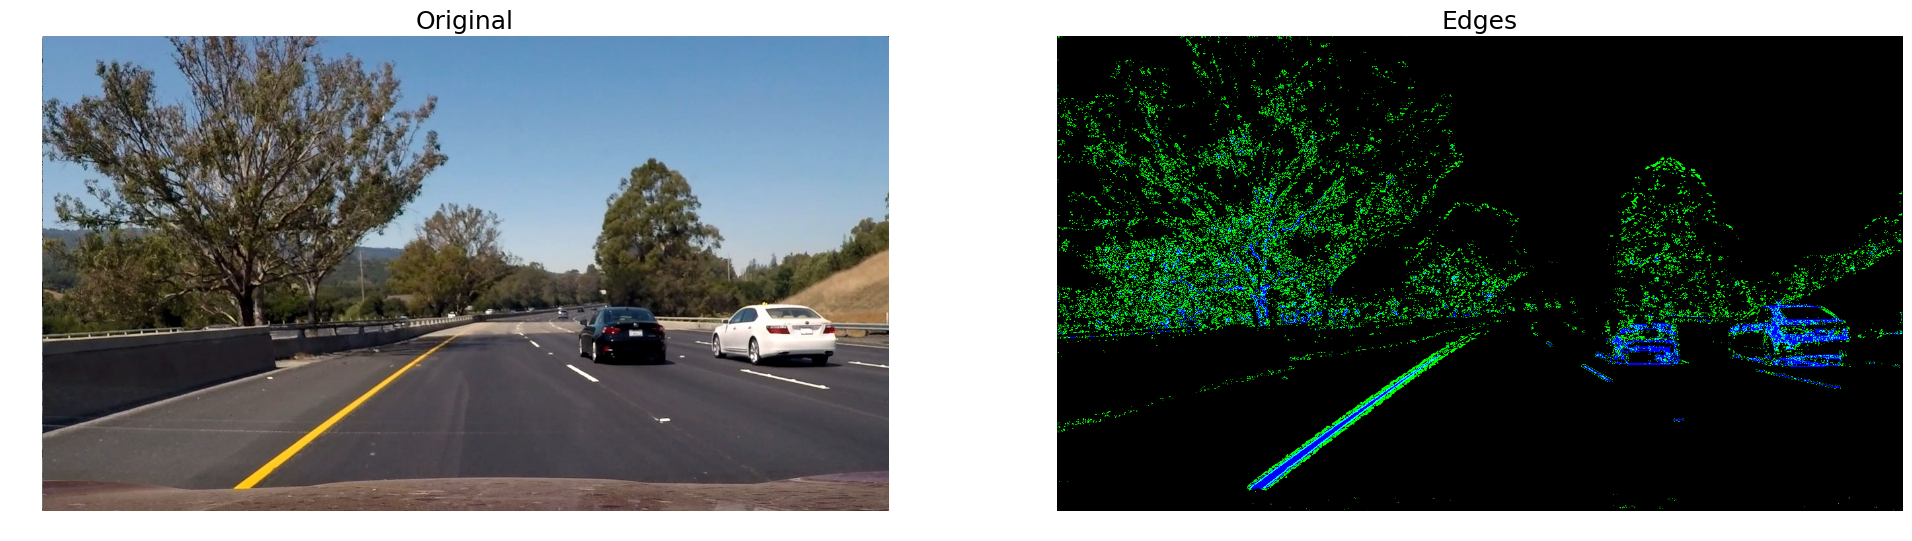

In [3]:
image = mpimg.imread('test_images/test6.jpg')
result = get_edges(image, separate_channels=True)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result)
ax2.set_title('Edges', fontsize=18)

Perspective transform

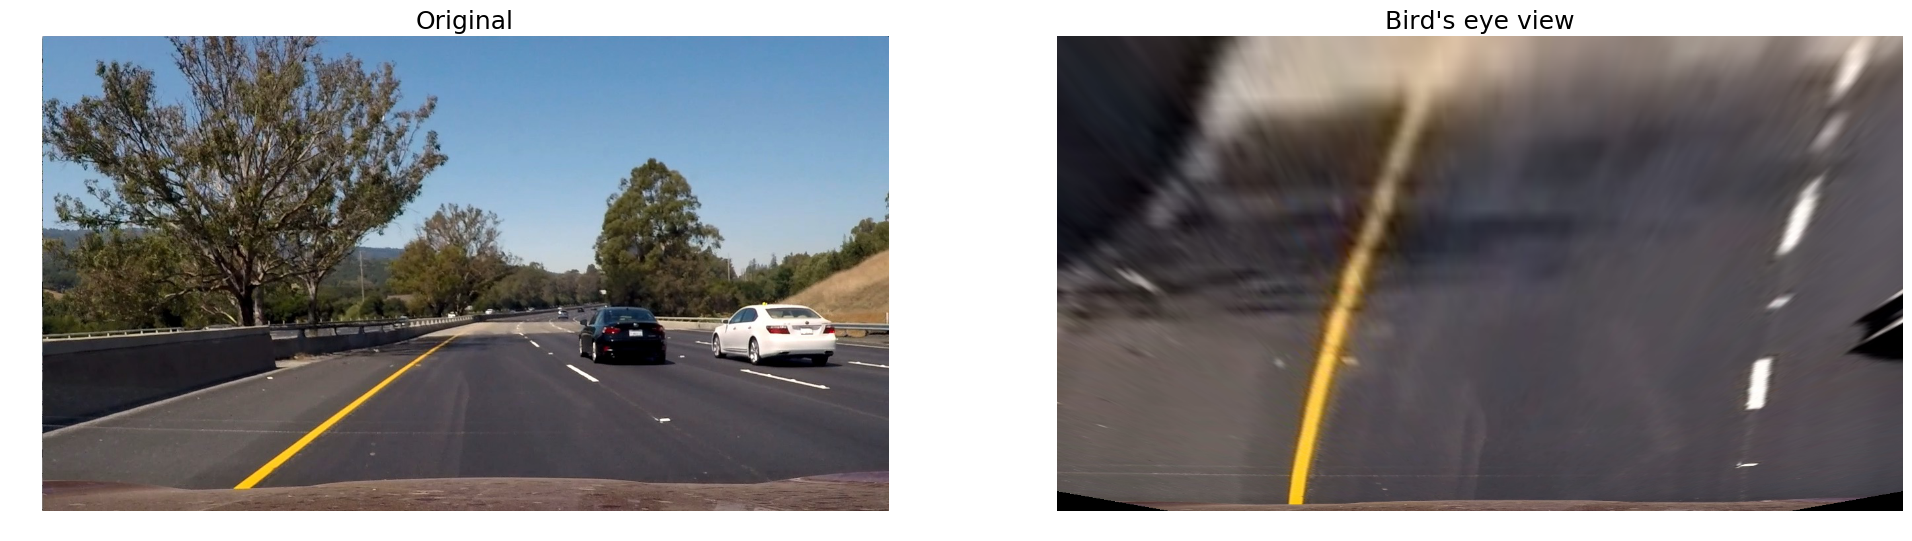

In [4]:
image = mpimg.imread('test_images/test6.jpg')
result, _ = flatten_perspective(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result)
ax2.set_title('Bird\'s eye view', fontsize=18)

Finding the lines

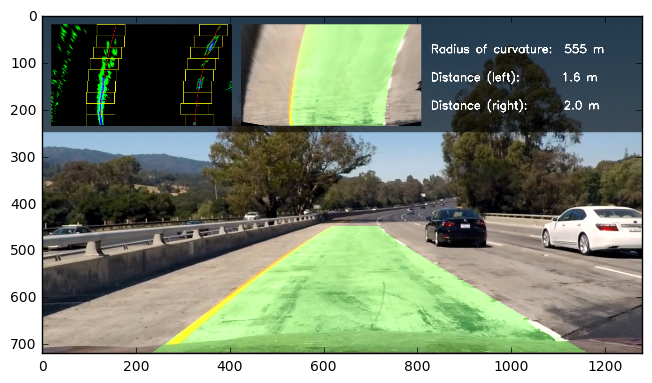

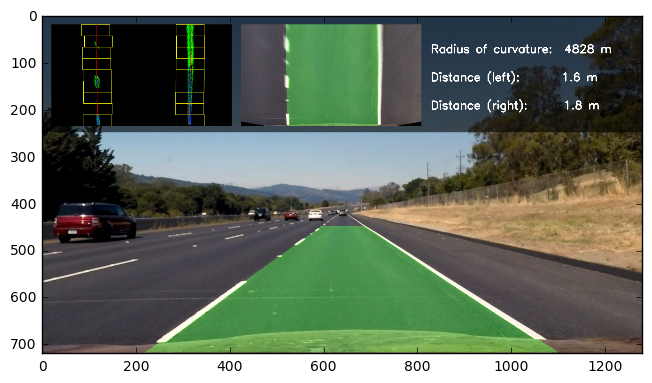

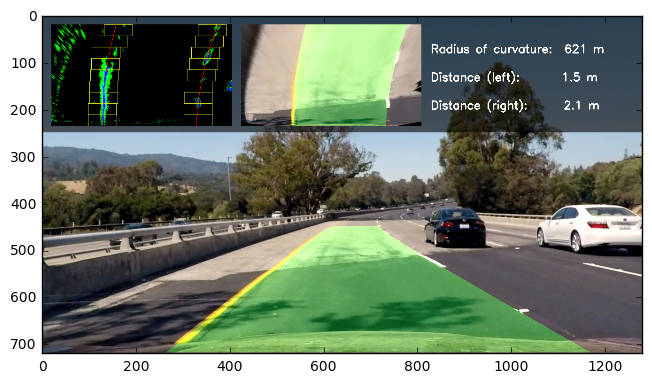

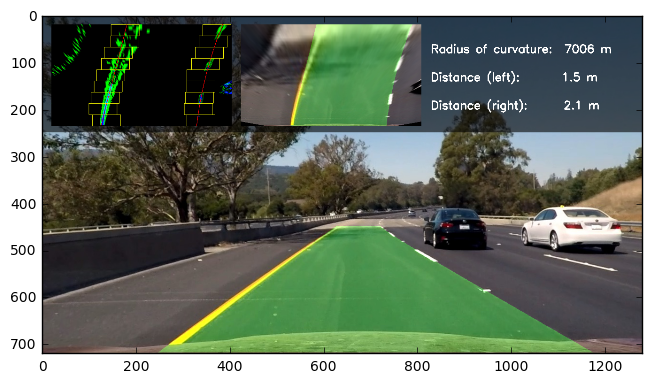

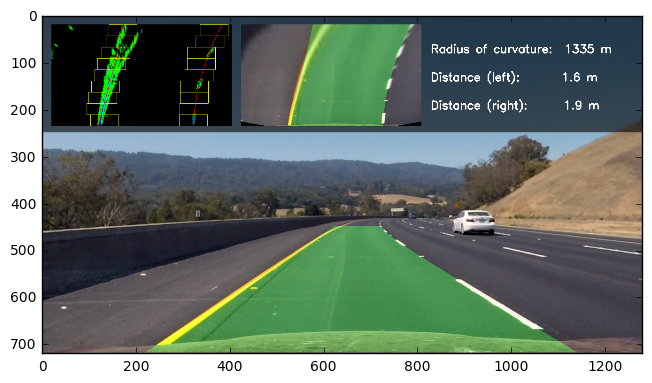

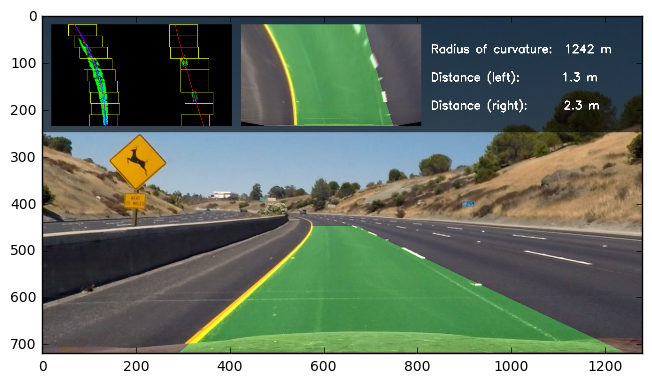

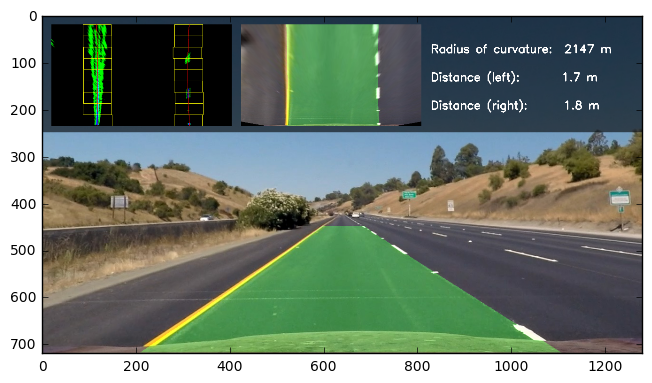

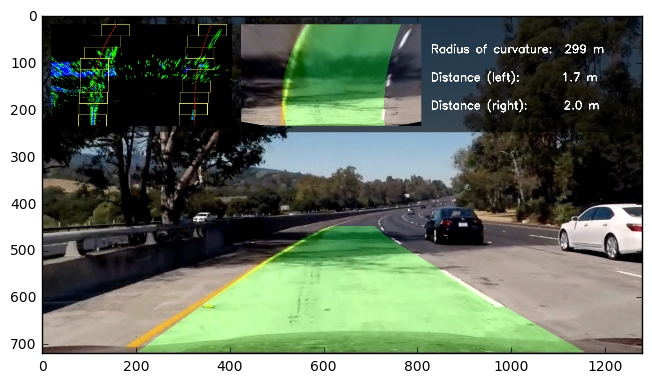

In [5]:
for image_name in glob.glob('test_images/*.jpg'):
    calibrated = calibrate(mpimg.imread(image_name))
    lane_tracker = LaneTracker(calibrated)
    overlay_frame = lane_tracker.process(calibrated, draw_lane=True, draw_statistics=True)
    mpimg.imsave(image_name.replace('test_images', 'output_images'), overlay_frame)
    plt.imshow(overlay_frame)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

Applying pipeline to video

In [ ]:
from moviepy.editor import VideoFileClip

video_output_name = 'video/project_video_annotated.mp4'
video = VideoFileClip("video/project_video.mp4")
tracker = LaneTracker(calibrate(video.get_frame(0)))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

# Vehicle Tracking

Train a classifier.

In [51]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from vehicletracker.tracker import extract_features
from vehicletracker.utilities import print_progress

print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('data/non-vehicles/*/*.png')
cars_files = glob.glob('data/vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])

print('Extracting features...')
car_features = extract_features(cars)
notcar_features = extract_features(notcars)
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('    ...Done')

print('Scaling features...')
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('    ...Done')

print('Training classifier...')
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('    ...Done')
print('Accuracy =', accuracy)

Reading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Vehicles images: 8792
Non-vehicles images: 8968
Extracting features...
    ...Done
Scaling features...
    ...Done
Training classifier...
    ...Done
Accuracy = 0.9752


126 regions, 4 with cars.


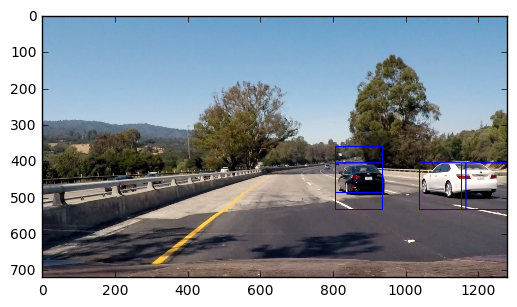

In [74]:
from vehicletracker.tracker import get_regions
from vehicletracker.tracker import extract_features

image = (mpimg.imread('test_images/test4.jpg') / 255.)
# scale = .2 to 1.
regions, regions_coordinates = get_regions(image, scale=.5, k=64)
regions_features = extract_features(regions)
# Apply the scaler to X
scaled_regions_features = X_scaler.transform(regions_features)
predictions = svc.predict(scaled_regions_features)
print(regions.shape[0], 'regions,', int(predictions.sum()), 'with cars.')

for c in regions_coordinates[predictions == 1]:
    cv2.rectangle(image, (c[0], c[1]), (c[2], c[3]), (0, 0, 1.), 2)
    
plt.imshow(image)
plt.show()